## Занятие 11. Инференс нейросетей

### 1. Описание проблемы
Инференс нейросетей может выполняться очень по-разному:

1. **С помощью какого фреймворка и ЯП обучена сеть?** 
    Например: PyTorch, Tensorflow, JAX, PaddlePaddle, NeoML

2. **На каком вычислителе выполняется инференс?**
    Например: x86, ARM, GPU, TPU, специализированные ускорители ([NPU](https://en.wikipedia.org/wiki/AI_accelerator))

3. **В каком окружении происходит вызов?**
    Например: bare-metal микроконтроллер без OS - или в Docker контейнере в Kubernetes


Обычно хочется выполнять инференс:
- эффективно для разных окружений и ускорителей 
- единообразно для разных сетей

Из-за множества разных комбинаций появляются как специализированные продукты ([ArmNN](https://developer.arm.com/Tools%20and%20Software/ArmNN)) для отдельных сценариев, так и универсальные решения.

### 2. Open Neural Network Exchange
ONNX(https://github.com/onnx/) - открытый расширяемый стандарт описания нейронных сетей, а также экосистема из многих программных продуктов для поддержки стандарта.

Нейросети определяются как вычислительный граф операторов над данными.

Пример оператора Conv: https://github.com/onnx/onnx/blob/main/docs/Operators.md#conv

Пример расширения стандарта кастомным оператором: 
Conv NHWC: https://github.com/microsoft/onnxruntime/blob/main/docs/ContribOperators.md#com.microsoft.NhwcConv


In [1]:
%pip uninstall onnxruntime-openvino -y
%pip install onnx onnxruntime-gpu segmentation-models-pytorch==0.3.2

Note: you may need to restart the kernel to use updated packages.


  Using cached onnxruntime_gpu-1.16.2-cp310-cp310-win_amd64.whl.metadata (4.4 kB)
Using cached onnxruntime_gpu-1.16.2-cp310-cp310-win_amd64.whl (141.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
import onnx
from matplotlib import pyplot as plt

C:\Users\bzimka\.conda\envs\ort118\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = smp.Linknet(
    encoder_name='mobilenet_v2', 
    encoder_weights='imagenet', 
    classes=8, 
    activation='softmax'
).eval()

model.load_state_dict(torch.load('swim_linknet.state_dict'))#

<All keys matched successfully>

torch.Size([1, 3, 256, 256])

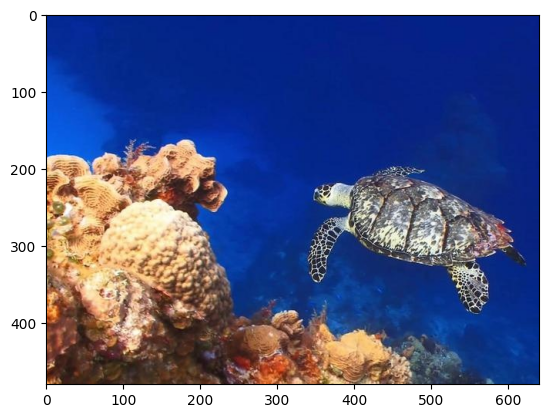

In [5]:
img = plt.imread('f_r_74_.jpg').astype(np.float32) / 255
plt.imshow(img)

from torchvision import transforms
x0 = torch.tensor(img).permute(2, 0, 1)[None]
x_bt = transforms.functional.resize(
    
    x0, size=(256, 256), 
    interpolation=transforms.functional.InterpolationMode.BILINEAR
)

x_bt.shape

C:\Users\bzimka\.conda\envs\ort118\lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


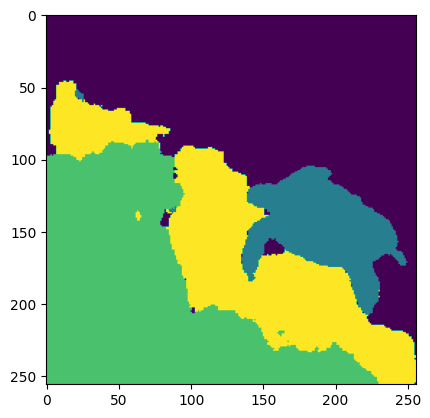

In [6]:
with torch.no_grad():
    yp = model(x_bt)[0]
plt.imshow(np.argmax(yp, axis=0))

In [7]:
y = model(x_bt)
y.shape

torch.Size([1, 8, 256, 256])

In [8]:
torch.onnx.export(
    model, x_bt, "linknet.onnx",
    input_names=['image'], output_names=['mask']
)

C:\Users\bzimka\.conda\envs\ort118\lib\site-packages\segmentation_models_pytorch\base\model.py:16: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h % output_stride != 0 or w % output_stride != 0:
C:\Users\bzimka\.conda\envs\ort118\lib\site-packages\torch\nn\modules\module.py:1527: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return forward_call(*args, **kwargs)


Конвертация выполняется с помощью отслеживания (Tracing) операций.
Warning стоит читать - они могут означать, что конвертированная операция работает иначе, чем оригинал

Сконвертированную модель можно визуализировать - например, с помощью https://github.com/lutzroeder/netron

Можно открыть модель программно с помощью пакета `onnx` (https://github.com/onnx/onnx)


In [9]:
model_onnx_spec = onnx.load('linknet.onnx')
onnx.checker.check_model(model_onnx_spec)

In [10]:
input_all = [node.name for node in model_onnx_spec.graph.input]
input_all

['image']

In [11]:
output_all = [node.name for node in model_onnx_spec.graph.output]
output_all

['mask']

ONNX - формат определения (описания) модели.

Непосредственно инференс модели - отдельная задача, которая может выполняться любыми движками инференса, поддерживающими onnx.

Наиболее популярный и user-friendy движок - `onnxruntime` (https://github.com/microsoft/onnxruntime)

In [12]:
import onnxruntime as ort
from pathlib import Path
import os
import torch 
import numpy as np
from matplotlib import pyplot as plt

In [13]:
ort_sess = ort.InferenceSession(
    'linknet.onnx', 
    providers=['CPUExecutionProvider']
)


Вход: torch.Size([1, 3, 256, 256]), Выход (1, 8, 256, 256)


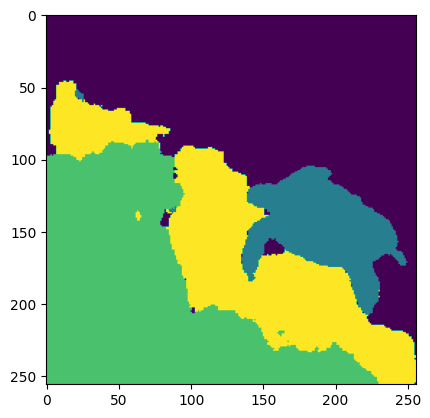

In [14]:
outputs = ort_sess.run(output_names=['mask'], input_feed={'image': x_bt.numpy()})
print(f"Вход: {x_bt.shape}, Выход {outputs[0].shape}")
plt.imshow(np.argmax(outputs[0][0], axis=0))

### Динамические оси
По умолчанию считается, что все тензоры имеют статический размер.

Использование иного размера **вызывает ошибку.**

In [15]:
outputs = ort_sess.run(
    output_names=['mask'], 
    input_feed={'image': np.random.rand(1, 3, 300, 300).astype(np.float32)}
)

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: image for the following indices
 index: 2 Got: 300 Expected: 256
 index: 3 Got: 300 Expected: 256
 Please fix either the inputs or the model.

In [16]:
torch.onnx.export(
    model, x_bt, "linknet_dynamic_hw.onnx",
    input_names=['image'], output_names=['mask'],
    dynamic_axes={'image': [0, 2, 3]}
)

C:\Users\bzimka\.conda\envs\ort118\lib\site-packages\torch\onnx\utils.py:2082: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input image
  warnings.warn(


Вход: torch.Size([1, 3, 224, 288]), Выход (1, 8, 224, 288)


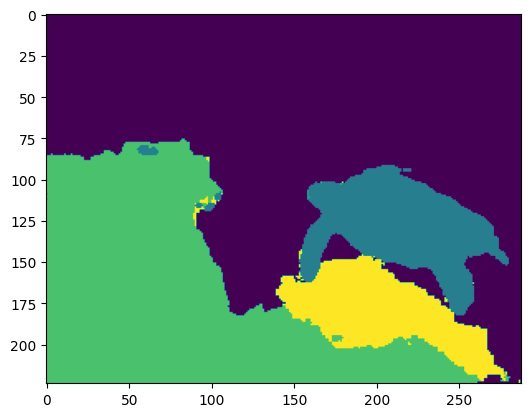

In [17]:
x_bt = transforms.functional.resize(
    x0, size=(224, 288), 
    interpolation=transforms.functional.InterpolationMode.BILINEAR
)
ort_sess = ort.InferenceSession(
    'linknet_dynamic_hw.onnx', 
    providers=['CPUExecutionProvider']
)
outputs = ort_sess.run(
    output_names=['mask'], 
    input_feed={'image': x_bt.numpy()}
)
outputs[0].shape
print(f"Вход: {x_bt.shape}, Выход {outputs[0].shape}")
plt.imshow(np.argmax(outputs[0][0], axis=0))

ONNX позволяет строить разные графы - но tracing кода на torch не всегда срабатывает корректно.

Часто проблемы возникают с динамическими осями.
#### Пример ошибочной конвертации

In [18]:
model_mbn = smp.Linknet(
    encoder_name='timm-mobilenetv3_small_minimal_100', # Другой энкодер - из стандартных timm
    encoder_weights='imagenet', 
    classes=8, 
    activation='softmax'
)

torch.onnx.export(
    model_mbn, x_bt, "linknet_dynamic_hw_mbn_timm.onnx",
    input_names=['image'], output_names=['mask'],
    dynamic_axes={'image': [2, 3]}
)

C:\Users\bzimka\.conda\envs\ort118\lib\site-packages\timm\models\layers\padding.py:19: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return max((math.ceil(x / s) - 1) * s + (k - 1) * d + 1 - x, 0)
C:\Users\bzimka\.conda\envs\ort118\lib\site-packages\timm\models\layers\padding.py:19: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return max((math.ceil(x / s) - 1) * s + (k - 1) * d + 1 - x, 0)
C:\Users\bzimka\.conda\envs\ort118\lib\site-packages\timm\models\layers\padding.py:31: TracerWarning: Converting a tensor to a Python boolean might cause the trace to

In [19]:
ort_sess = ort.InferenceSession(
    'linknet_dynamic_hw_mbn_timm.onnx', 
    providers=['CPUExecutionProvider']
)

x = np.random.rand(1, 3, 224, 224).astype(np.float32)
outputs = ort_sess.run(
    output_names=['mask'], 
    input_feed={'image': x}
)
print(f"Вход: {x.shape}, Выход {outputs[0].shape}")


x = np.random.rand(1, 3, 320, 320).astype(np.float32)
outputs = ort_sess.run(
    output_names=['mask'], 
    input_feed={'image': x}
)
print(f"Вход: {x.shape}, Выход {outputs[0].shape}") 

Вход: (1, 3, 224, 224), Выход (1, 8, 224, 288)
Вход: (1, 3, 320, 320), Выход (1, 8, 224, 288)


In [20]:
# Conv-same с stride=2 - требует не тривиальных вычислений в общем случае
model_mbn.encoder.model.conv_stem

Conv2dSame(3, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)

Причина проблемы в данном случае - использование динамического padding, определяемого Shape.

https://github.com/rwightman/pytorch-image-models/blob/v0.6.13/timm/models/layers/conv2d_same.py#L16

Исправить неверную конвертацию затруднительно - обычно проще не использовать такие сложные конструкции в модели. 

1. **Тестируйте модель после конвертации в ONNX**
1. **Проверяйте визуализации графа ONNX на разумность**


### 3.Задачка: исправьте конвертацию модели

In [21]:
class NormalizedVectorSum(torch.nn.Module):
    """
    Принимает батч векторов X[N, S]
    Возвращает сумму всех элементов, нормированную на количество элментов тензора.
    Y[0] = Sum(X[n, i]) / (N * S)
    """
    def forward(self, ns_t: torch.Tensor) -> torch.Tensor:
        norm = float(ns_t.nelement())
        return torch.sum(ns_t, axis=[0, 1], keepdims=True) / norm


In [22]:
nvs = NormalizedVectorSum()
x_t = torch.rand(4, 546)

In [23]:
torch.onnx.export(
    nvs, x_t, "nvs.onnx",
    input_names=['batch_vectors'], output_names=['result'],
    dynamic_axes={'batch_vectors': [0, 1]}
)

C:\Users\bzimka\.conda\envs\ort118\lib\site-packages\torch\onnx\utils.py:2082: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input batch_vectors
  warnings.warn(
C:\Users\bzimka\AppData\Local\Temp\ipykernel_64920\3890584856.py:8: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  norm = float(ns_t.nelement())


In [24]:
ort_sess = ort.InferenceSession(
    'nvs.onnx', 
    providers=['CPUExecutionProvider']
)

outputs = ort_sess.run(
    output_names=['result'], 
    input_feed={'batch_vectors': x_t.numpy()}
)
print(f"ORT: {outputs[0]}, torch:{nvs(x_t)}") 

ORT: [[0.49357453]], torch:tensor([[0.4936]])


In [25]:
x_t = torch.rand(3, 1200)

outputs = ort_sess.run(
    output_names=['result'], 
    input_feed={'batch_vectors': x_t.numpy()}
)
print(f"ORT: {outputs[0]}, torch: {nvs(x_t)}") 

ORT: [[0.8281593]], torch: tensor([[0.5024]])


### 4.Сравнение скорости torch и onnxruntime

In [26]:
%%writefile {Path().absolute() / 'runners.py'}

import time
import torch
import numpy as np

class TorchRunner:
    """
    Запуск модели с замерами времени
    """
    def __init__(self, net, device):
        self.net = net
        self.device = device
    
    def __call__(self, x: np.ndarray):
        x_t = torch.tensor(x, device=self.device)
        with torch.no_grad():
            y_t = self.net(x_t).cpu().numpy()
        return y_t
    
    @classmethod
    def measure_times(cls, samples, freq=10, **cls_kwargs):
        runner = cls(**cls_kwargs)
        start = time.time_ns()
        
        times = []
        
        start0 = time.time_ns()
        start = start0
        for num, s in enumerate(samples):
            y = runner(s)
            if ((num + 1) % freq) == 0:
                times.append((time.time_ns() - start)/freq /1e6)
                start = time.time_ns()
                
        print(f"Average time: {(time.time_ns() - start0) / (num + 1) / 1e6}")
        return times
    
class OrtRunner(TorchRunner):
    def __init__(self, ort_inference_session, input_name):
        self.session = ort_inference_session
        self.input_name = input_name
    
    def __call__(self, x: np.ndarray):
        outputs = self.session.run(
            output_names=None,
            input_feed={self.input_name: x}
        )
        return outputs
    

Writing F:\bzimka\edu\course_cvdl\classes\c11\runners.py


In [27]:
from runners import OrtRunner, TorchRunner

In [28]:
N_TIMES = 100
SHAPE = (1, 3, 224*3, 224*3)
RESULTS = dict()

Average time: 111.173023


Text(0.5, 0, 'ms')

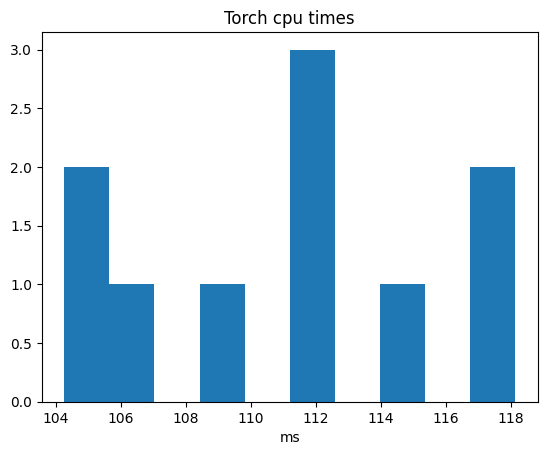

In [29]:
RESULTS['torch_cpu'] = TorchRunner.measure_times(
    (np.random.rand(*SHAPE).astype(np.float32) for _ in range(N_TIMES)),
    net=model.to('cpu'), 
    device=torch.device('cpu'),
)
plt.hist(RESULTS['torch_cpu'])
plt.title('Torch cpu times')
plt.xlabel('ms')

Average time: 66.87551


Text(0.5, 0, 'ms')

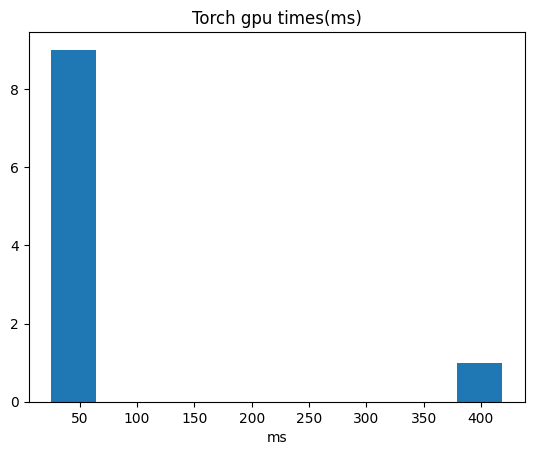

In [30]:
RESULTS['torch_gpu'] = TorchRunner.measure_times(
    (np.random.rand(*SHAPE).astype(np.float32) for _ in range(N_TIMES)),
    net=model.to('cuda:0'), 
    device=torch.device('cuda:0'),
)
plt.hist(RESULTS['torch_gpu'])
plt.title('Torch gpu times(ms)')
plt.xlabel('ms')

In [31]:
if SHAPE == (1, 3, 224, 224):
    RESULTS['ort_cpu'] = OrtRunner.measure_times(
        (np.random.rand(*SHAPE).astype(np.float32) for _ in range(N_TIMES)),
        ort_inference_session=ort.InferenceSession(
            'linknet.onnx', 
            providers=['CPUExecutionProvider']
        ),
        input_name='image'
    )
    plt.hist(RESULTS['ort_cpu'])
    plt.title('ORT cpu times')
else:
    print("Static axis require specific shape")

Static axis require specific shape


Average time: 123.128495


Text(0.5, 1.0, 'ORT cpu dynamic times')

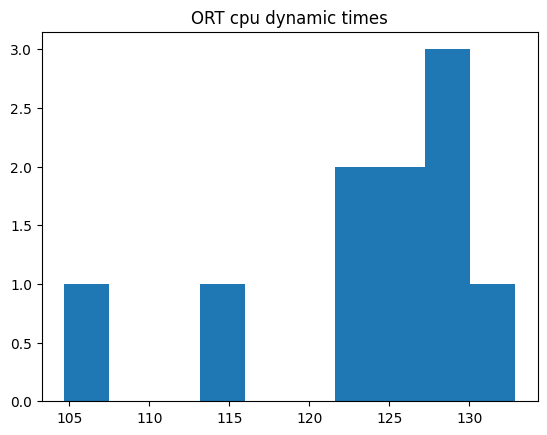

In [32]:
RESULTS['ort_cpu_dynamic'] = OrtRunner.measure_times(
    (np.random.rand(*SHAPE).astype(np.float32) for _ in range(N_TIMES)),
    ort_inference_session=ort.InferenceSession(
        'linknet_dynamic_hw.onnx', 
        providers=['CPUExecutionProvider']
    ),
    input_name='image'
)
plt.hist(RESULTS['ort_cpu_dynamic'])
plt.title('ORT cpu dynamic times')

Average time: 57.181366


Text(0.5, 1.0, 'ORT cuda times')

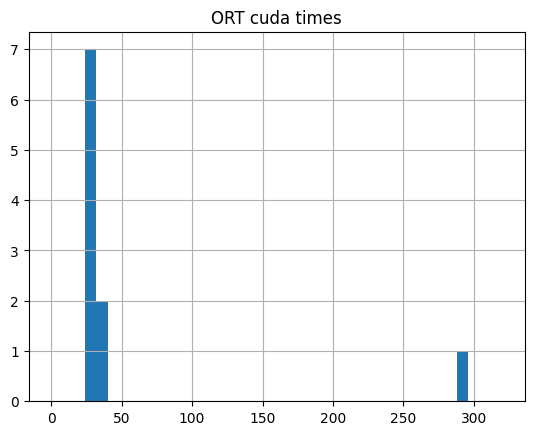

In [33]:
RESULTS['ort_cuda_dynamic'] = OrtRunner.measure_times(
    (np.random.rand(*SHAPE).astype(np.float32) for _ in range(N_TIMES)),
    ort_inference_session=ort.InferenceSession(
        'linknet_dynamic_hw.onnx', 
        providers=['CUDAExecutionProvider']
    ),
    input_name='image'
)
plt.hist(RESULTS['ort_cuda_dynamic'], bins=40, range=(0, 320))
plt.grid()
plt.title('ORT cuda times')

In [35]:
import json

with open("results.json", "w") as f:
    f.write(json.dumps(RESULTS))

## 5. Использование ONNXRuntime providers
ORT может использовать различные сторонние проекты в качестве provider: https://onnxruntime.ai/docs/execution-providers/

В такмом варианте OnnxRuntime служит общим интерфейсом к разным инференс движками.

Пример - Intel OpenVino provider

RESTART

In [1]:
! pip uninstall onnxruntime -y
! pip uninstall onnxruntime-gpu -y
! pip install onnxruntime-openvino openvino

Found existing installation: onnxruntime 1.16.2
Uninstalling onnxruntime-1.16.2:
  Successfully uninstalled onnxruntime-1.16.2
Found existing installation: onnxruntime-gpu 1.16.2
Uninstalling onnxruntime-gpu-1.16.2:
  Successfully uninstalled onnxruntime-gpu-1.16.2
  Using cached onnxruntime_openvino-1.16.0-cp310-cp310-win_amd64.whl.metadata (4.9 kB)
Using cached onnxruntime_openvino-1.16.0-cp310-cp310-win_amd64.whl (5.5 MB)


## RESTART notebook

In [1]:
import json

with open("results.json", "r") as f:
    RESULTS = json.loads(f.read())

In [2]:
import onnxruntime.tools.add_openvino_win_libs as utils
utils.add_openvino_libs_to_path()

In [3]:
import onnxruntime as ort
from pathlib import Path
import os
import torch 
import numpy as np
from matplotlib import pyplot as plt

from runners import OrtRunner, TorchRunner
N_TIMES = 100
SHAPE = (1, 3, 256 * 3, 256 * 3)

In [4]:
ort.get_available_providers()

['OpenVINOExecutionProvider', 'CPUExecutionProvider']

Average time: 229.403104


Text(0.5, 1.0, 'Basic cpu dynamic times')

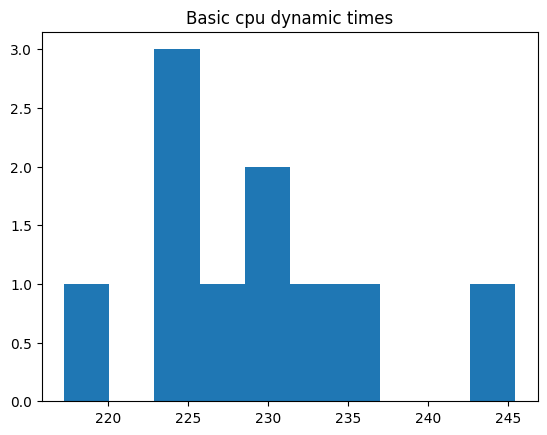

In [9]:
RESULTS['ort_cpu2'] = OrtRunner.measure_times(
    (np.random.rand(*SHAPE).astype(np.float32) for _ in range(N_TIMES)),
    ort_inference_session=ort.InferenceSession(
    'linknet_dynamic_hw.onnx', 
        providers=['CPUExecutionProvider']
    ),
    input_name='image'
)

plt.hist(RESULTS['ort_cpu2'])
plt.title('Basic cpu dynamic times')

Average time: 72.661867


Text(0.5, 1.0, 'OpenVINO cpu dynamic times')

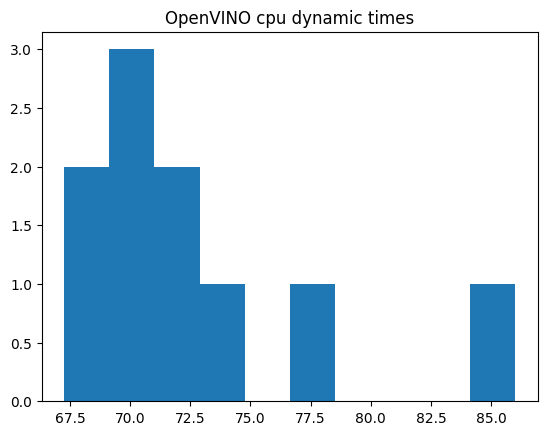

In [8]:
RESULTS['ort_openvino'] = OrtRunner.measure_times(
    (np.random.rand(*SHAPE).astype(np.float32) for _ in range(N_TIMES)),
    ort_inference_session=ort.InferenceSession(
        'linknet_dynamic_hw.onnx', 
        providers=['OpenVINOExecutionProvider']
    ),
    input_name='image'
)
plt.hist(RESULTS['ort_openvino'])
plt.title('OpenVINO cpu dynamic times')

Text(0.5, 1.0, 'Сравнение времени работы')

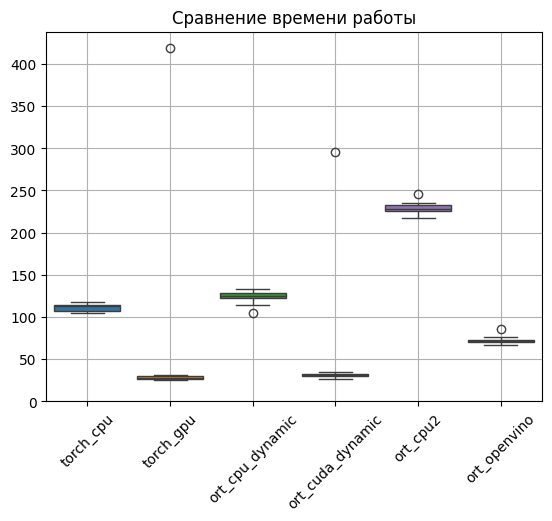

In [19]:
import seaborn as sns
ks = list(RESULTS.keys())
sns.boxplot(RESULTS)
plt.xticks(rotation=45)
plt.grid()
plt.gca().set_ylim([0, None])
plt.title("Сравнение времени работы")

### 6. Оптимизация моделей

В ORT есть опция включения ряда оптимизация графа.

Average time: 189.074743


Text(0.5, 1.0, 'ORT cpu optimized dynamic times')

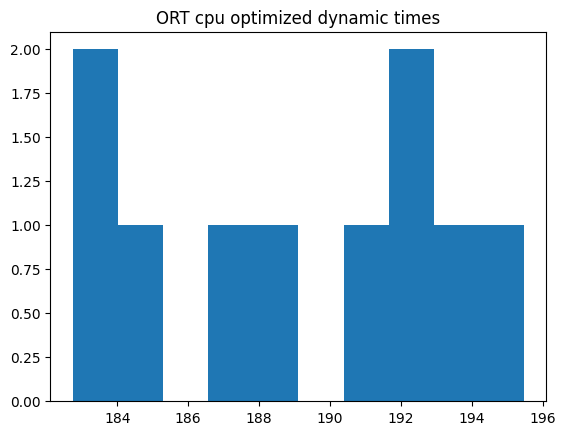

In [7]:
sess_options = ort.SessionOptions()

sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL

plt.hist(
    OrtRunner.measure_times(
        (np.random.rand(*SHAPE).astype(np.float32) for _ in range(N_TIMES)),
        ort_inference_session=ort.InferenceSession(
            'linknet_dynamic_hw.onnx', 
            providers=['CPUExecutionProvider'],
            session_options=sess_options
        ),
        input_name='image'
    )
)
plt.title('ORT cpu optimized dynamic times')

In [11]:
! onnxsim linknet_dynamic_hw_mbn_timm.onnx linknet_dynamic_hw_mbn_timm_optim.onnx

Your model contains "Tile" ops or/and "ConstantOfShape" ops. Folding these ops 
can make the simplified model much larger. If it is not expected, please 
specify "--no-large-tensor" (which will lose some optimization chances)
Simplifying...
Finish! Here is the difference:
+--------------------------------------------------------+
|                    | Original Model | Simplified Model |
|--------------------+----------------+------------------|
| Add                | 10             | 10               |
| BatchNormalization | 5              | 5                |
| Cast               | 30             | 0                |
| Concat             | 15             | 5                |
| Constant           | 217            | 120              |
| ConstantOfShape    | 5              | 0                |
| Conv               | 45             | 45               |
| ConvTranspose      | 5              | 5                |
| Div                | 10             | 10               |
| Gather           

### 7. Model Serving
Частый сценарий инференса - вызов через сетевой интерфейс, т.е. REST/gRPC API поверх HTTP

Пример:
- запрос из мобильного приложения к облачному веб-сервису на сервере с GPU
- запрос из одного микросервиса Kubernetes к микросервису вычислений
- запрос из jupyter-notebook к модели на подключённой к локальной сети RaspberryPi

Плюсы:
- контролируемое и масштабируемое окружение
- конфиденциальность модели и данных

Для этого сценария есть отдельные более специализированные решения.
Примеры:
- tensorflow-serving, torchserve
- nvidia [triton](https://github.com/triton-inference-server/server)
- kserve, [bentoml](https://www.bentoml.com/), seldom

Обычно решаются несколько другие проблемы, например:
- батчинг запросов (несколько клиентов - один батч на GPU)
- очереди, асинхронные запрос-ответы
- автомасштабирование при превышении Requests-per-second
- мониторинг памяти / производительности


### Пример: bentoml
Использует onnxruntime как один из backend

In [20]:
%pip uninstall onnxruntime-openvino -y
%pip install onnxruntime

Found existing installation: onnxruntime-openvino 1.16.0Note: you may need to restart the kernel to use updated packages.

Uninstalling onnxruntime-openvino-1.16.0:
  Successfully uninstalled onnxruntime-openvino-1.16.0


You can safely remove it manually.


  Using cached onnxruntime-1.16.2-cp310-cp310-win_amd64.whl.metadata (4.4 kB)
Using cached onnxruntime-1.16.2-cp310-cp310-win_amd64.whl (7.4 MB)
Note: you may need to restart the kernel to use updated packages.


## RESTART

In [1]:
import onnx
import numpy as np

In [2]:
model_onnx_spec = onnx.load('linknet_dynamic_hw.onnx')

In [3]:
import bentoml
import onnxruntime

signatures = {
    "run": {"batchable": True},
}
bentoml.onnx.save_model("linknet", model_onnx_spec, signatures=signatures)

Model(tag="linknet:tbkzy2ug7cupj5gh", path="C:\Users\bzimka\bentoml\models\linknet\tbkzy2ug7cupj5gh\")

In [4]:
%%writefile linkenet_service.py
import bentoml

import numpy as np
from bentoml.io import NumpyNdarray

bento_model = bentoml.onnx.get("linknet:latest")
runner = bento_model.with_options(providers=["CPUExecutionProvider"]).to_runner()
svc = bentoml.Service("linknet", runners=[runner])

@svc.api(input=NumpyNdarray(), output=NumpyNdarray())
async def segment(x) -> np.ndarray:
    y = await runner.run.async_run(np.array(x))
    return y

Writing linkenet_service.py


In [5]:
from matplotlib import pyplot as plt
import torch
from torchvision import transforms

img = plt.imread('f_r_74_.jpg').astype(np.float32) / 255
from torchvision import transforms
x0 = torch.tensor(img).permute(2, 0, 1)[None]
x_bt = transforms.functional.resize(
    x0, size=(256, 256), 
    interpolation=transforms.functional.InterpolationMode.BILINEAR
)

C:\Users\bzimka\.conda\envs\ort118\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


'Runner.init_local' is for debugging and testing only. Make sure to remove it before deploying to production.
C:\Users\bzimka\.conda\envs\ort118\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


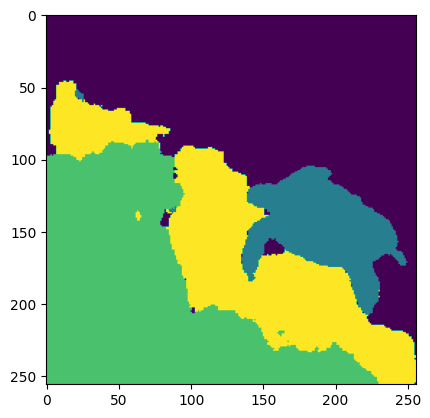

In [6]:
runner = bentoml.onnx.get("linknet").to_runner()

runner.init_local()

y = runner.run.run(x_bt.numpy())[0]
plt.imshow(np.argmax(y, axis=0))

In [7]:
del runner

python -m bentoml serve-grpc linkenet_service:svc --reload --enable-reflection --development

In [8]:
import grpc
import numpy as np
from bentoml.grpc.utils import import_generated_stubs
from bentoml.io import NumpyNdarray

pb, services = import_generated_stubs()


In [9]:
with grpc.insecure_channel("localhost:3000") as channel:
    stub = services.BentoServiceStub(channel)

    req: pb.Response = stub.Call(
        request=pb.Request(
            api_name="segment",
            ndarray=pb.NDArray(
               dtype=pb.NDArray.DTYPE_FLOAT,
               shape=(1, 3, 256, 256),
               float_values=x_bt.numpy().flatten()
            ),
      )
    )
    response = await NumpyNdarray().from_proto(req.ndarray)
response.shape

(1, 8, 256, 256)

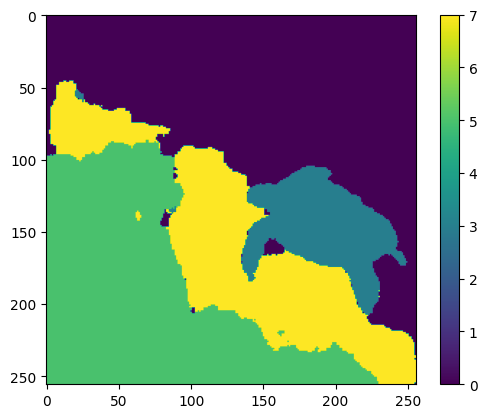

In [10]:
plt.imshow(np.argmax(response[0], axis=0))
plt.colorbar()